In [1]:
import glob
import re
import json 
import itertools
import functools
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
mats = glob.glob('../../genome_correlations/gro_seq_200k_genes/*.temp')

In [3]:
mats

['../../genome_correlations/gro_seq_200k_genes/cont_1.m.temp',
 '../../genome_correlations/gro_seq_200k_genes/cont_1.p.temp',
 '../../genome_correlations/gro_seq_200k_genes/cont_2.m.temp',
 '../../genome_correlations/gro_seq_200k_genes/cont_2.p.temp',
 '../../genome_correlations/gro_seq_200k_genes/drb.m.temp',
 '../../genome_correlations/gro_seq_200k_genes/drb.p.temp',
 '../../genome_correlations/gro_seq_200k_genes/GS-CONT1_dedup_RPM5ETS_n.temp',
 '../../genome_correlations/gro_seq_200k_genes/GS-CONT1_dedup_RPM5ETS_p.temp',
 '../../genome_correlations/gro_seq_200k_genes/GS-CONT2_dedup_RPM5ETS_n.temp',
 '../../genome_correlations/gro_seq_200k_genes/GS-CONT2_dedup_RPM5ETS_p.temp',
 '../../genome_correlations/gro_seq_200k_genes/GS-DRB_dedup_RPM5ETS_n.temp',
 '../../genome_correlations/gro_seq_200k_genes/GS-DRB_dedup_RPM5ETS_p.temp',
 '../../genome_correlations/gro_seq_200k_genes/GS-KM_dedup_RPM5ETS_n.temp',
 '../../genome_correlations/gro_seq_200k_genes/GS-KM_dedup_RPM5ETS_p.temp']

In [4]:
sample_extractor = re.compile('/GS-([^/]+)_dedup_RPM5ETS_([np]).temp')

In [5]:
sample_extractor.findall('../../genome_correlations/gro_seq_200k_genes/GS-CONT1_dedup_RPM5ETS_n.temp')

[('CONT1', 'n')]

In [6]:
filename_correspondence = {i: sample_extractor.findall(i)[0] for i in mats if sample_extractor.findall(i)}

In [7]:
def ucsc_index(df):
    return df.chr.str.cat(df.start.astype(str).str.cat(df.end.astype(str).str.cat(df.strand.astype(str), sep=';'), sep='-'), sep=':')

def read_matrix_file(f):
    temp = pd.read_csv(f, compression='gzip', comment='@', sep='\t', header=None)
    # Generate a UCSC style description of the peak coordinates
    ucsc_idx = (temp.iloc[:, 0].str.cat(
                    temp.iloc[:, 1].astype(str).str.cat(
                        temp.iloc[:, 2].astype(str).str.cat( 
                            temp.iloc[:, 5].astype(str), sep = ';'),
                    sep= '-'), 
                sep=':'))
    # Drop the first 6 columns, which here act as a descriptor
    return temp.set_index(ucsc_idx).drop(range(6), axis=1).fillna(0)

In [8]:
tss_data = {}
for filename, samplename in filename_correspondence.items():
    print(samplename)
    tss_data[samplename] = read_matrix_file(filename)

('CONT1', 'n')
('CONT1', 'p')
('CONT2', 'n')
('CONT2', 'p')
('DRB', 'n')
('DRB', 'p')
('KM', 'n')
('KM', 'p')


In [9]:
gene_data_names = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg19/hg19_gencode28_gene_names.tsv.gz', 
                             sep='\t', compression = 'gzip'
                       )

In [10]:
used_genes = pd.read_csv('/Volumes/Pegasus/shared_files/bed_files/hg19/hg19_gv28_over_50k.bed',
                         sep ='\t', names = ('chr', 'start', 'end', 'gencode', 'expr', 'strand'))

In [11]:
used_genes = used_genes.merge(gene_data_names[['name', 'name2']].rename(columns = {'name': 'gencode', 'name2': 'symbol'}), how='left')

In [12]:
used_genes[used_genes.symbol == 'RASA2']

,chr,start,end,gencode,expr,strand,symbol
12917,chr3,141205890,141334184,ENST00000286364.7_1,.,+,RASA2
12918,chr3,141205925,141331155,ENST00000452898.2_1,.,+,RASA2


In [13]:
used_genes['ucsc_name'] = ucsc_index(used_genes)

In [14]:
used_genes['gene_length'] = pd.to_numeric(used_genes.end, errors='coerce') - pd.to_numeric(used_genes.start, errors='coerce')

In [15]:
sense_data = {k[0]: v.copy() for k,v in tss_data.items() if k[1] == 'n'}
for sample, matrix in sense_data.items():
    minus_gene_set = set(used_genes.loc[used_genes.strand == '-', 'ucsc_name'])
    matrix.loc[matrix.index.isin(minus_gene_set), :] = tss_data[(sample, 'p')].iloc[np.where(matrix.index.isin(minus_gene_set))[0],:]
antisense_data = {k[0]: v.copy() for k,v in tss_data.items() if k[1] == 'p'}
for sample, matrix in antisense_data.items():
    matrix.loc[matrix.index.isin(minus_gene_set), :] = tss_data[(sample, 'n')].iloc[np.where(matrix.index.isin(minus_gene_set))[0],: ]
    

In [16]:
sense_data.keys()

dict_keys(['CONT1', 'CONT2', 'DRB', 'KM'])

# Plot mean enrichment for long genes (both replicates)

Text(0.5,0,'Distance from TSS')

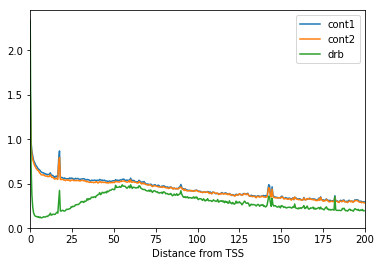

In [17]:
fig, ax = plt.subplots()

x = np.arange(0, 200, 0.5)
long_subset = used_genes.loc[used_genes.gene_length > 5e4, 'ucsc_name']
ax.plot(x, antisense_data['CONT1'].loc[antisense_data['CONT1'].index.isin(long_subset)].mean(axis=0),label ='cont1' )
ax.plot(x, antisense_data['CONT2'].loc[antisense_data['CONT2'].index.isin(long_subset)].mean(axis=0),label ='cont2' )
ax.plot(x, antisense_data['DRB'].loc[antisense_data['DRB'].index.isin(long_subset)].mean(axis=0),label ='drb' )

ax.legend()
ax.set_xlim(0, 200)
ax.set_xlabel('Distance from TSS')

In [18]:
antisense_data['CONT1'].iloc[:, 102].sort_values()

0
chrY:59214046-59274659;+         0.000000
chr18:25531044-25616549;-        0.000000
chr18:26858473-26941928;-        0.000000
chr18:28569973-28622707;-        0.000000
chr18:28570051-28622781;-        0.000000
chr18:28681550-28742752;+        0.000000
chr18:28923330-29006890;-        0.000000
chr18:28927630-29006951;-        0.000000
chr5:139227233-139422732;-       0.000000
chr18:29203131-29264686;-        0.000000
chr5:139226363-139422884;-       0.000000
chr5:139064229-139124595;+       0.000000
chr18:29598334-29653176;+        0.000000
chr18:29598791-29691742;+        0.000000
chr18:29843484-30050447;-        0.000000
chr18:29847462-30050395;-        0.000000
chr18:30050250-30325530;+        0.000000
chr18:30252633-30353025;-        0.000000
chr18:30415127-30518280;+        0.000000
chr18:30517365-30716041;-        0.000000
chr18:25530929-25757410;-        0.000000
chr18:30517366-31020045;-        0.000000
chr18:24916656-24972831;-        0.000000
chr18:24495742-24765262;-       

In [19]:
set_to_remove = {'chr2:229888689-230135981;-',
                 'chr2:229888710-230136001;-',
                 'chr2:229888704-230135996;-', 
                 'chr12:20522178-20837315;+',
                 'chr2:229890292-230096801;-'
                }

Text(0.5,0,'Distance from TSS')

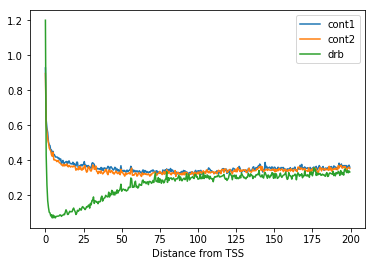

In [20]:
fig, ax = plt.subplots()

x = np.arange(0, 200, 0.5)
long_subset = set(used_genes.loc[used_genes.gene_length > 2e5, 'ucsc_name'])
long_subset = long_subset - set_to_remove
ax.plot(x, antisense_data['CONT1'].loc[antisense_data['CONT1'].index.isin(long_subset)].mean(axis=0),label ='cont1' )
ax.plot(x, antisense_data['CONT2'].loc[antisense_data['CONT2'].index.isin(long_subset)].mean(axis=0),label ='cont2' )
ax.plot(x, antisense_data['DRB'].loc[antisense_data['DRB'].index.isin(long_subset)].mean(axis=0),label ='drb' )

ax.legend()
ax.set_xlabel('Distance from TSS')

# Plot mean enrichment for long genes (mean of 2 replicates)

In [21]:
up_color = '#cc3311'
down_color = '#3366cf'

In [22]:
def bootstrap_samples(mat, n_samples, agg_func = np.mean, verbose=False, sample_name = ''):
    agg_func = functools.partial(agg_func, axis=0)
    boot_samples = np.empty((n_samples, mat.shape[1]), dtype=np.float32)
    for i in range(n_samples):
        if verbose and not i % (n_samples // 25):
            print(sample_name, (i / n_samples) * 100)
        boot_samples[i, :] = agg_func(mat[np.random.choice(len(mat), len(mat), replace=True), :])
    return boot_samples

def mean_95_ci(ax, mat, color='blue'):
    x = np.arange(0, 200, 0.5)
    ax.plot(x, mat.mean(axis=0), color=color)
    ax.fill_between(x, 
                    np.percentile(mat, 2.5, axis=0), 
                    np.percentile(mat, 97.5, axis=0),
                    alpha = 0.5, color=color)

In [23]:
?pickle.dump

In [24]:
bootstrapped_data = {}
long_subset = set(used_genes.loc[used_genes.gene_length > 2e5, 'ucsc_name'])
long_subset = long_subset - set_to_remove
for name, mat_data in antisense_data.items():
    if 'KM' in name:
        continue
    bootstrapped_data[name] = bootstrap_samples(mat_data.loc[mat_data.index.isin(long_subset), :].as_matrix(), 
                                                5000, verbose=True, sample_name=name)

    

CONT1 0.0
CONT1 4.0
CONT1 8.0
CONT1 12.0
CONT1 16.0
CONT1 20.0
CONT1 24.0
CONT1 28.000000000000004
CONT1 32.0
CONT1 36.0
CONT1 40.0
CONT1 44.0
CONT1 48.0
CONT1 52.0
CONT1 56.00000000000001
CONT1 60.0
CONT1 64.0
CONT1 68.0
CONT1 72.0
CONT1 76.0
CONT1 80.0
CONT1 84.0
CONT1 88.0
CONT1 92.0
CONT1 96.0
CONT2 0.0
CONT2 4.0
CONT2 8.0
CONT2 12.0
CONT2 16.0
CONT2 20.0
CONT2 24.0
CONT2 28.000000000000004
CONT2 32.0
CONT2 36.0
CONT2 40.0
CONT2 44.0
CONT2 48.0
CONT2 52.0
CONT2 56.00000000000001
CONT2 60.0
CONT2 64.0
CONT2 68.0
CONT2 72.0
CONT2 76.0
CONT2 80.0
CONT2 84.0
CONT2 88.0
CONT2 92.0
CONT2 96.0
DRB 0.0
DRB 4.0
DRB 8.0
DRB 12.0
DRB 16.0
DRB 20.0
DRB 24.0
DRB 28.000000000000004
DRB 32.0
DRB 36.0
DRB 40.0
DRB 44.0
DRB 48.0
DRB 52.0
DRB 56.00000000000001
DRB 60.0
DRB 64.0
DRB 68.0
DRB 72.0
DRB 76.0
DRB 80.0
DRB 84.0
DRB 88.0
DRB 92.0
DRB 96.0


In [25]:
bootstrapped_data.keys()

dict_keys(['CONT1', 'CONT2', 'DRB'])

In [26]:
up_color = '#cc3311'
down_color = '#3366cf'
down_color_alt = '#669cc6'

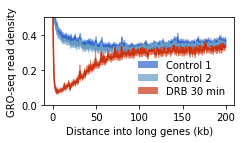

In [28]:
fig, ax = plt.subplots(figsize=(3.5,2))
mean_95_ci(ax, bootstrapped_data['CONT1'], color = down_color)
mean_95_ci(ax, bootstrapped_data['CONT2'], color = down_color_alt)
mean_95_ci(ax, bootstrapped_data['DRB'], color = up_color)
labels, handles = ax.get_legend_handles_labels()

ax.set_ylabel('GRO-seq read density')
ax.set_xlabel('Distance into long genes (kb)')

ax.set_ylim(0, 0.5)

handles = [
    mpl.patches.Patch(facecolor=down_color, alpha=0.7),
    mpl.patches.Patch(facecolor=down_color_alt, alpha=0.7),
    mpl.patches.Patch(facecolor=up_color, alpha=0.7),
]

labels = ['Control 1', 'Control 2', 'DRB 30 min']
ax.legend(handles, labels, frameon=False, labelspacing = 0.3, markerscale=0.4)
fig.tight_layout()
fig.savefig('GRO-seq-DRB.svg')

[Text(0,0,''), Text(0,0,''), Text(0,0,''), Text(0,0,''), Text(0,0,'')]


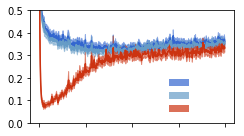

In [33]:
fig, ax = plt.subplots(figsize=(3.5,2))
mean_95_ci(ax, bootstrapped_data['CONT1'], color = down_color)
mean_95_ci(ax, bootstrapped_data['CONT2'], color = down_color_alt)
mean_95_ci(ax, bootstrapped_data['DRB'], color = up_color)
labels, handles = ax.get_legend_handles_labels()

print([i for i in ax.get_yticklabels()])
# Get rid of x- and y-axis labels
ax.set_ylabel('')
ax.set_xlabel('')
# A little tricky: [''] * N (where N is an integer) will make a list of N empty strings (try it out!)
# So we're getting the number of ticks with len(ax.get_xticklabels()) and then
# just creating a new list with empty labels
ax.set_xticklabels([''] * len(ax.get_xticklabels()))
#ax.set_yticklabels([''] * len(ax.get_yticklabels()))

ax.set_ylim(0, 0.5)

handles = [
    mpl.patches.Patch(facecolor=down_color, alpha=0.7),
    mpl.patches.Patch(facecolor=down_color_alt, alpha=0.7),
    mpl.patches.Patch(facecolor=up_color, alpha=0.7),
]

labels = ['         ', '        ', '        ']
ax.legend(handles, labels, frameon=False, labelspacing = 0.3, markerscale=0.4)
fig.tight_layout()
fig.savefig('GRO-seq-DRB_no_label.svg')

In [210]:
?ax.legend

In [223]:
def ordered_matrix(mat, order_matrix=None, agg_func = np.mean):
    if order_matrix is None:
        order_matrix = mat
    agg_func = functools.partial(agg_func, axis=1)
    return mat[np.argsort(agg_func(order_matrix))[::-1], :]

In [221]:
antisense_data.keys()

dict_keys(['CONT1', 'CONT2', 'DRB', 'KM'])

In [125]:
!echo $(whoami)@$HOSTNAME:$(pwd)

cimprich@cimprichserver.stanford.edu:/Volumes/Pegasus/DRIP_spike_in/qdrip/notebooks/metaplots
